***
##### NYU Programming Tools for Data Scientists, CSCI-US 381
##### Spring 2025
##### Course Project
## Analysis of Financial Time Series
#### Yuri Chentsov, Amish Vandse, Benson Yu
***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from scipy.stats import skew, kurtosis, jarque_bera, shapiro
from fredapi import Fred

In [2]:
# remove some annoying warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set seaborn styles
sns.set_style("darkgrid") 
sns.set_context("notebook") 
sns.set_palette("muted") 

***
### 1. Historical data upload

Time series with price levels of different instruments are uploaded from __[FRED (Federal Reserve Economic Data)](https://fred.stlouisfed.org/)__ - an economic database maintained by the Federal Reserve Bank of St.Louis. We will be using the daily values for the last 10 years.

Please note, the api_key below is a personal FRED API key of one of the project team members.
You must register on the FRED website to obtain a __[personal API key](https://fred.stlouisfed.org/docs/api/api_key.html)__ if you
intend to use the code in the future.

In [4]:
# Initialize FRED API
fred = Fred(api_key='78c214dcb7cc402d047e1001c7c602c8')

In [5]:
series_ids = {
    'SP500': 'SP500',  # S&P 500 Index
    'US_10Y': 'DGS10',  # 10-Year Treasury Rate
    'Oil': 'DCOILWTICO',  # Crude Oil Prices
    'Bitcoin': 'CBBTCUSD'  # Bitcoin Prices
}

In [6]:
def fetch_fred_data(fred_instance, series_ids, start_date='2015-01-01'):
    """
    Fetch data from FRED for multiple series
    """
    data = pd.DataFrame()
    
    for name, series_id in series_ids.items():
        try:
            series = fred_instance.get_series(series_id, start_date)
            if data.empty:
                data = pd.DataFrame(series, columns=[name])
            else:
                data[name] = series
        except ValueError as e:
            print(f"Error fetching {name} ({series_id}): {str(e)}")
            continue
    
    return data

*Note: FRED database connection periodically experiences some issues with respect to Proxy Authentication, so the data request fails. In this case re-running the data request (or restarting the kernel) usually works fine.*

In [7]:
# Fetch the data
data = fetch_fred_data(fred, series_ids)
data.tail(10)

,SP500,US_10Y,Oil,Bitcoin
2025-04-23,5375.86,4.40,62.64,94021.96
2025-04-24,5484.77,4.32,63.55,94708.79
2025-04-25,5525.21,4.29,63.85,94666.64
2025-04-28,5528.75,4.23,63.30,94271.09
2025-04-29,5560.83,4.19,61.84,94182.54
2025-04-30,5569.06,4.17,59.55,96524.98
2025-05-01,5604.14,4.25,60.59,96929.81
2025-05-02,5686.67,4.33,59.67,95861.33
2025-05-05,5650.38,4.36,58.50,96839.17
2025-05-06,5606.91,4.30,NaN,96809.95


In [8]:
# basic stats
data.describe().round(3)

,SP500,US_10Y,Oil,Bitcoin
count,2515.000,2500.000,2503.000,2608.000
mean,3481.011,2.564,62.736,23322.546
std,1140.323,1.104,18.315,25522.792
min,1829.080,0.520,-36.980,211.160
25%,2530.565,1.730,49.035,3844.222
50%,3192.520,2.370,61.720,10680.170
75%,4348.600,3.480,74.450,37846.535
max,6144.150,4.980,123.640,106159.260


In [9]:
# number of missing datapoints
data.isna().sum()

SP500       94
US_10Y     109
Oil        106
Bitcoin      1
dtype: int64

*Note: Missing data filling and/or removal is not done at this state to keep integrety of the data for correct return calculations.
(missing days should lead to missing daily return calculations for that and the next days, not some made-up numbers).*

In [10]:
# saving raw data just in case
data.to_csv('ptds_project_data.csv')

***
### 2. Returns Calculation and Normalization

In [11]:
def calculate_returns(data, period='D', yield_columns=[]):
    """
    Calculate returns for all series, handling both prices and yields
    
    Parameters:
    data (pd.DataFrame): Price/yield data
    period (str): 'D' for daily, 'W' for weekly, 'M' for monthly
    yield_columns (list): List of column names that contain yields
    
    Returns:
    pd.DataFrame: Returns data
    """
    # Resample if needed
    # TODO: use some 'select-case' + handling of unsupported periods
    if period == 'W':
        data = data.resample('W').last()
    elif period == 'M':
        data = data.resample('ME').last()
    
    # Initialize returns DataFrame
    returns = pd.DataFrame(index=data.index)
    
    # Calculate returns for each column
    for column in data.columns:
        if column in yield_columns:
            # For yield series, return = - difference
            returns[column] = -data[column].diff()
        else:
            # For price series, return = percentage change
            returns[column] = data[column].pct_change(fill_method=None)
    
    return returns 

In [12]:
# run the calcs for different time periods
daily_returns = calculate_returns(data, 'D')
weekly_returns = calculate_returns(data, 'W')
monthly_returns = calculate_returns(data, 'M')

In [13]:
# some sanity checks
daily_returns.tail(10)

,SP500,US_10Y,Oil,Bitcoin
2025-04-23,0.016661,-0.002268,-0.030341,0.002998
2025-04-24,0.020259,-0.018182,0.014527,0.007305
2025-04-25,0.007373,-0.006944,0.004721,-0.000445
2025-04-28,0.000641,-0.013986,-0.008614,-0.004178
2025-04-29,0.005802,-0.009456,-0.023065,-0.000939
2025-04-30,0.001480,-0.004773,-0.037031,0.024871
2025-05-01,0.006299,0.019185,0.017464,0.004194
2025-05-02,0.014727,0.018824,-0.015184,-0.011023
2025-05-05,-0.006382,0.006928,-0.019608,0.010201
2025-05-06,-0.007693,-0.013761,NaN,-0.000302


*Note: Missing price levels correctly lead to missing returns for the corresponding days.*

In [14]:
print("Daily returns summary:")
daily_returns.describe().round(4)

Daily returns summary:


,SP500,US_10Y,Oil,Bitcoin
count,2420.0000,2390.0000,2404.0000,2606.0000
mean,0.0005,0.0008,-0.0007,0.0032
std,0.0116,0.0299,0.0740,0.0422
min,-0.1198,-0.2703,-3.0197,-0.3741
25%,-0.0038,-0.0132,-0.0130,-0.0146
50%,0.0007,0.0000,0.0013,0.0020
75%,0.0059,0.0139,0.0141,0.0202
max,0.0952,0.4074,0.5309,0.2720


In [15]:
print("Weekly returns summary:")
weekly_returns.describe().round(4)

Weekly returns summary:


,SP500,US_10Y,Oil,Bitcoin
count,522.0000,522.0000,522.0000,522.0000
mean,0.0022,0.0031,0.0021,0.0160
std,0.0239,0.0602,0.0683,0.0952
min,-0.1498,-0.3451,-0.3859,-0.3896
25%,-0.0096,-0.0306,-0.0274,-0.0285
50%,0.0037,0.0000,0.0025,0.0098
75%,0.0151,0.0296,0.0320,0.0646
max,0.1210,0.4000,0.8320,0.5057


In [16]:
print("Monthly returns summary:")
monthly_returns.describe().round(4)

Monthly returns summary:


,SP500,US_10Y,Oil,Bitcoin
count,120.0000,120.0000,120.0000,120.0000
mean,0.0092,0.0124,0.0078,0.0735
std,0.0444,0.1136,0.1291,0.2216
min,-0.1251,-0.3805,-0.5425,-0.3763
25%,-0.0176,-0.0453,-0.0593,-0.0761
50%,0.0156,0.0140,0.0056,0.0535
75%,0.0352,0.0630,0.0639,0.2019
max,0.1268,0.3091,0.8497,0.7019


For comparison purposes and ML methods later on, it is also worth normalizing the returns, so they all have zero mean and unit standard deviation.

In [17]:
daily_returns_standard = StandardScaler().set_output(transform='pandas').fit_transform(daily_returns)
weekly_returns_standard = StandardScaler().set_output(transform='pandas').fit_transform(weekly_returns)
monthly_returns_standard = StandardScaler().set_output(transform='pandas').fit_transform(monthly_returns)

In [18]:
# sanity check to make sure we've normalized
daily_returns_standard.describe().round(4)

,SP500,US_10Y,Oil,Bitcoin
count,2420.0000,2390.0000,2404.0000,2606.0000
mean,0.0000,0.0000,0.0000,-0.0000
std,1.0002,1.0002,1.0002,1.0002
min,-10.3650,-9.0631,-40.8249,-8.9527
25%,-0.3677,-0.4691,-0.1668,-0.4222
50%,0.0194,-0.0277,0.0271,-0.0280
75%,0.4629,0.4382,0.2001,0.4032
max,8.1497,13.5922,7.1881,6.3783


***
### 3. Analysis of Return Distributions

In [19]:
def analyze_distributions(returns):
    """
    Analyze return distributions for normality and other properties
    
    Parameters:
    returns (pd.DataFrame): Returns data
    
    Returns:
    pd.DataFrame: Distribution statistics
    """
    distribution_stats = {}
    
    for column in returns.columns:
        series = returns[column].dropna()
        
        # Calculate basic statistics
        distribution_stats[column] = {
            'mean': series.mean(),
            'std': series.std(),
            'skew': skew(series),
            'kurtosis': kurtosis(series),
            'jarque_bera_stat': jarque_bera(series).statistic,
            'jarque_bera_pvalue': jarque_bera(series).pvalue,
            'shapiro_stat': shapiro(series).statistic,
            'shapiro_pvalue': shapiro(series).pvalue,
        }
        
    return pd.DataFrame(distribution_stats)


In [20]:
def plot_distributions(returns, title=""):
    """
    Plot return distributions with normal distribution overlay in 2 columns
    
    Parameters:
    returns (pd.DataFrame): Returns data
    title (str): Master title for the figure
    """
    n_assets = len(returns.columns)
    n_rows = (n_assets + 1) // 2  # This gives us ceiling division
    n_cols = 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4*n_rows))
    
    # Add master title
    fig.suptitle(title) # , fontsize=16, y=1.02)
    
    # Flatten axes array for easier iteration if we have multiple rows
    if n_rows > 1:
        axes = axes.flatten()
    
    for i, column in enumerate(returns.columns):
        sns.histplot(returns[column], kde=True, ax=axes[i], stat='proportion')
        axes[i].set_title(f'{column}')
        axes[i].set_xlabel('')
    
    # Hide empty subplots if odd number of assets
    if n_assets % 2 != 0:
        axes[-1].set_visible(False)
        
    plt.tight_layout()
    plt.show()

#### 3.1 Analysis of daily returns

To check normality we will be using Jarque-Bera and Shapiro-Wilk statistical tests. 

*Note: Shapiro-Wilk test may lose power for large sample like this (n > 2000), as even minor deviations from normality can be detected, leading to rejection of the null hypothesis. We still include it for unified aproach with weekly and monthly data later.*

In [21]:
# TODO: Probably can put the output dataframe into styling, so display is nicier 
analyze_distributions(daily_returns).round(4)

,SP500,US_10Y,Oil,Bitcoin
mean,0.0005,0.0008,-7.000000e-04,0.0032
std,0.0116,0.0299,7.400000e-02,0.0422
skew,-0.4032,1.4138,-2.999340e+01,0.0733
kurtosis,15.0978,34.8432,1.187624e+03,6.6506
jarque_bera_stat,23049.9217,121695.3290,1.416407e+08,4804.9692
jarque_bera_pvalue,0.0000,0.0000,0.000000e+00,0.0000
shapiro_stat,0.8690,0.8164,2.090000e-01,0.9198
shapiro_pvalue,0.0000,0.0000,0.000000e+00,0.0000


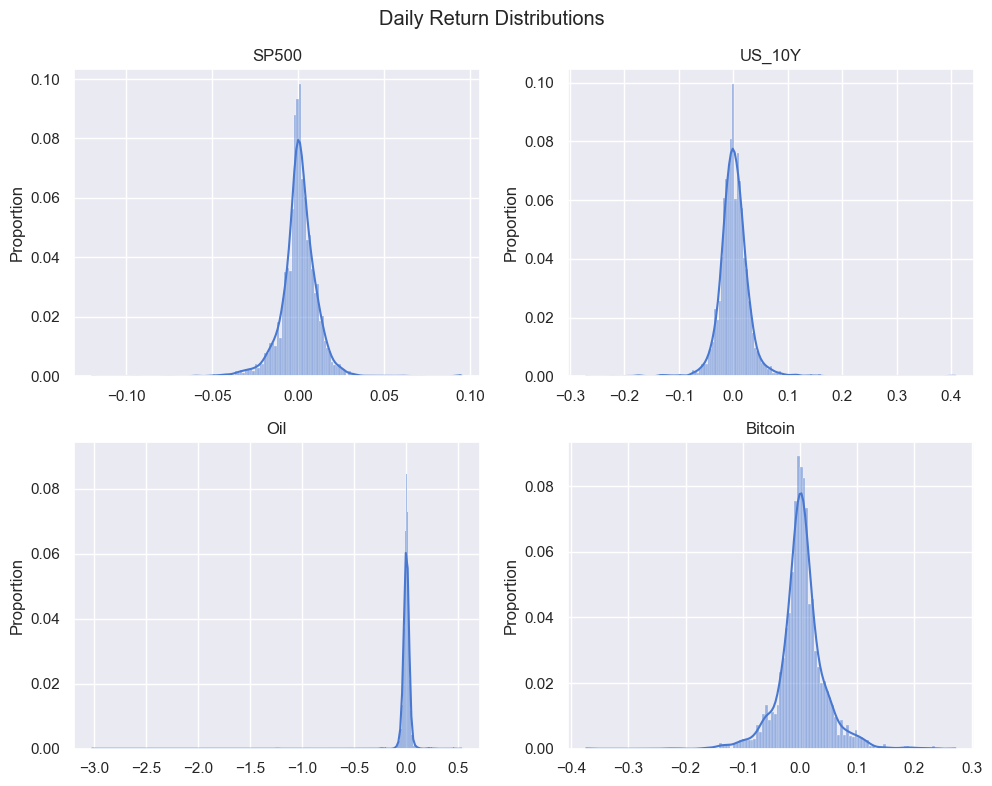

In [22]:
plot_distributions(daily_returns, "Daily Return Distributions")

#### Key findings about daily returns:

- Bitcoin demonstrates the highest **average** returns, approximately 6x higher than the S&P 500, while Oil is the only asset with negative average returns during this period.

- Oil exhibits the highest **volatility**, approximately 6.4x more volatile than S&P 500. This aligns with Oil's reputation for price instability.

- **Skewness**: oil showed extreme negative skew (frwquent small gains with occasional catastrophic losses), S&P 500 - moderate negative skew, Bitcoin - balanced upside/downside movement, and US Treasuries - a positive skew (tendency towards positive outliers, "flight to safety").

- **Kurtosis**: oil - extreme (exceptional tail risk), US Treasuries - significant tail risk, S&P 500 - moderate, and Bitcoin - lowest, but still elevated vs normal distribution (3.0). Exceptional oil tail risk is also very noticable on the chart.

- **Normality**: the distributions are not normal! Both Jarque-Bera and Shapiro-Wilk tests decisively reject the null hypothesis of normally distributed returns for all assets (all p-values ≈ 0). The Shapiro statistics suggest Bitcoin returns (0.92) are the closest to normal, while oil is dramatically non-normal.




#### 3.2 Analysis of weekly and monthly returns

##### Weekly

In [23]:
analyze_distributions(weekly_returns).round(4)

,SP500,US_10Y,Oil,Bitcoin
mean,0.0022,0.0031,0.0021,0.0160
std,0.0239,0.0602,0.0683,0.0952
skew,-0.6416,0.6554,3.1243,0.4168
kurtosis,6.1527,7.6530,43.7387,2.7461
jarque_bera_stat,859.1751,1311.2374,42458.4690,179.1357
jarque_bera_pvalue,0.0000,0.0000,0.0000,0.0000
shapiro_stat,0.9267,0.9035,0.7806,0.9616
shapiro_pvalue,0.0000,0.0000,0.0000,0.0000


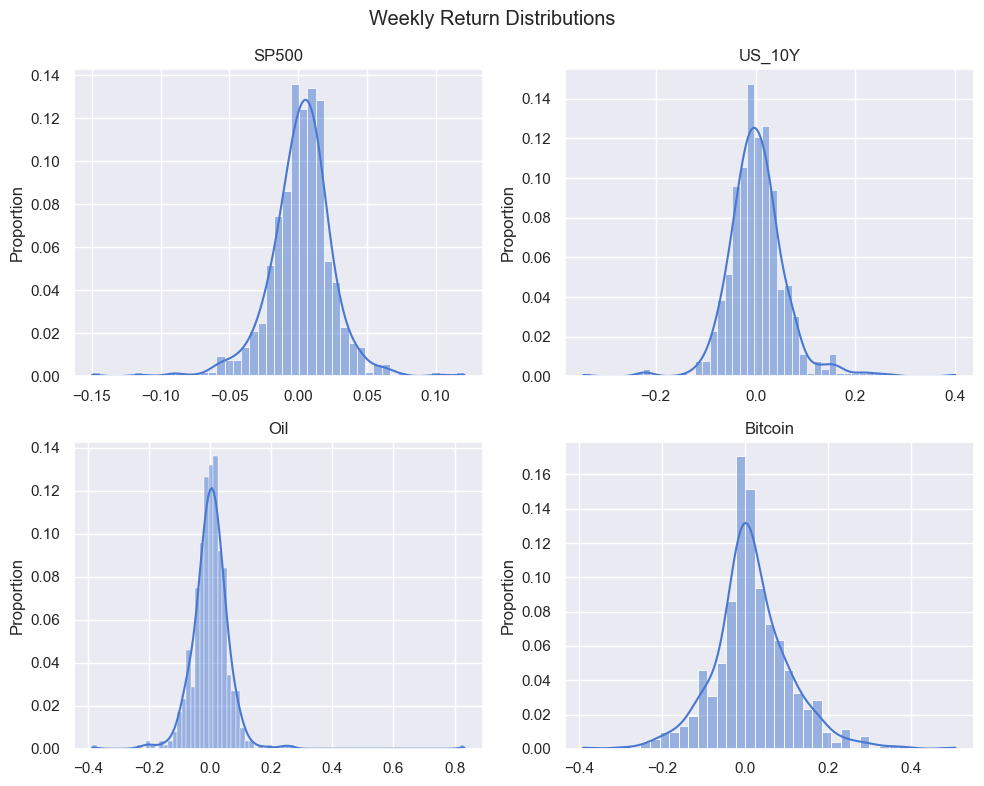

In [24]:
plot_distributions(weekly_returns, "Weekly Return Distributions")

#### Monthly

In [25]:
analyze_distributions(monthly_returns).round(4)

,SP500,US_10Y,Oil,Bitcoin
mean,0.0092,0.0124,0.0078,0.0735
std,0.0444,0.1136,0.1291,0.2216
skew,-0.3655,0.0517,1.6550,0.5385
kurtosis,0.4084,1.2639,15.8969,0.1135
jarque_bera_stat,3.5053,8.0406,1318.3374,5.8631
jarque_bera_pvalue,0.1733,0.0179,0.0000,0.0533
shapiro_stat,0.9835,0.9706,0.8080,0.9734
shapiro_pvalue,0.1498,0.0100,0.0000,0.0177


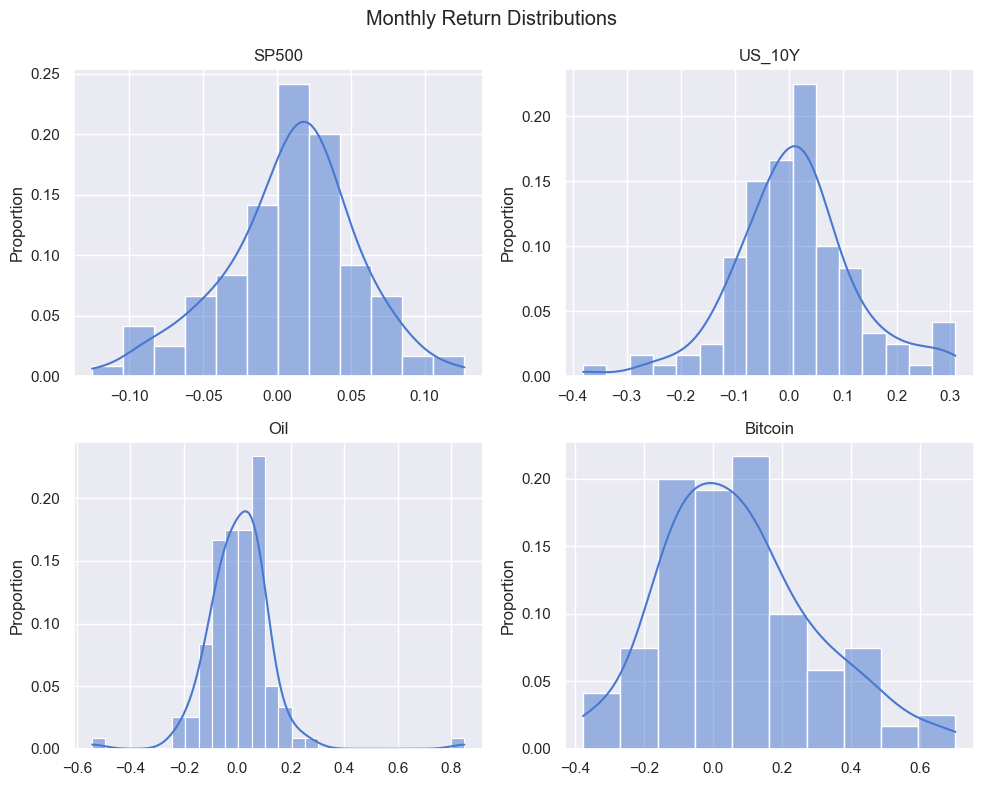

In [26]:
plot_distributions(monthly_returns, "Monthly Return Distributions")

#### Comparison of weekly and monthly distributions with daily ones:

- Returns scale up as expected with longer timeframes for all assets.

- Oil is most **volatile** at daily level, but Bitcoin takes over at weekly and monthly timeframes. S&P 500 remains least volatile across all periods.

- Both **skewness** and **kurtosis** values become dramatically less extreme at longer timeframes. This, along with the visual distribution patterns, hints to the distributions becoming closer to normal on longer timeframes. 

- **Normality**: Statistical tests for weekly returns still show strong (but decreasing) non-normality. Monthly returns, however, are approaching normal. For S&P 500 we cannot reject normality hypothesis (JB p-value: 0.167, Shapiro p-value: 0.137). Bitcoin is nearly normal at monthly level with marginally significant p-values.

- Oil: Remains significantly non-normal even at monthly intervals.


***
### 4. Correlation Analysys

In [27]:
def analyze_correlations(returns, window=252):
    """
    Analyze correlations between assets and their stability
    
    Parameters:
    returns (pd.DataFrame): Returns data
    window (int): Rolling window size for correlation calculation
    
    Returns:
    tuple: (Static correlations DataFrame, 
            Dictionary of rolling correlations for each pair)
    """

    returns_temp = returns.dropna()

    # Calculate static correlations
    # static will be the same, regardless of the window, as we're using full timeseries
    static_corr = returns_temp.corr()
    
    # Calculate rolling correlations for each pair
    rolling_corrs = {}
    
    # Get all unique pairs of assets
    assets = returns_temp.columns
    for i in range(len(assets)):
        for j in range(i+1, len(assets)):  # start from i+1 to avoid duplicates
            asset1 = assets[i]
            asset2 = assets[j]
            pair_name = f'{asset1} vs {asset2}'
            
            # Calculate rolling correlation for this pair
            rolling_corr = returns_temp[asset1].rolling(window=window).corr(returns_temp[asset2])
            rolling_corrs[pair_name] = rolling_corr
    
    return pd.DataFrame(static_corr), pd.DataFrame(rolling_corrs)


#### 4.1 Static Correlations (using full 10 year history)

In [28]:
# Calculate static correlation and rolling correlations using different lookback windows
static_corr, rolling_corr_1y = analyze_correlations(daily_returns, 252) # 252 trading days in a year
_, rolling_corr_3m = analyze_correlations(daily_returns, 70) # ~70 trading days in 3m
_, rolling_corr_1m = analyze_correlations(daily_returns, 22) # ~22 trading days in 1m 

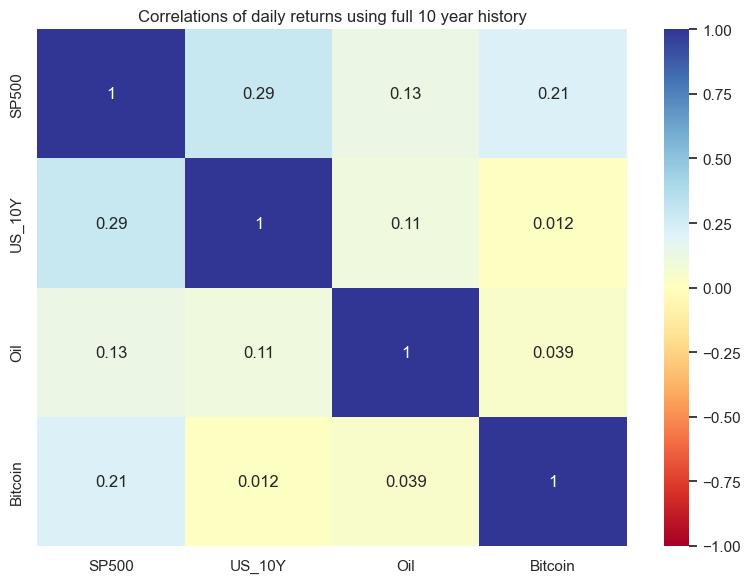

In [29]:
# Display static correlations as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(static_corr, annot=True, cmap='RdYlBu', vmin=-1, vmax=1, center=0)
plt.title('Correlations of daily returns using full 10 year history')
plt.tight_layout()

#### Analysis of static correlations:

All correlations are positive but relatively weak (all below 0.3), suggesting good diversification potential across these assets. The strongest correlation is between S&P 500 and US 10-Year yields (0.29), which is consistent with the "risk-on" market behavior where rising yields often accompany stock market gains. Bitcoin and Oil show the weakest correlations with other assets (most correlations below 0.1), making them potentially valuable diversification tools. The overall low correlation structure suggests these assets could work well together in a diversified portfolio, as they appear to be driven by different factors.

#### 4.2 Rolling Correlations

Now, instead of calculating correlations using full history, let's look at rolling correlations using different lookback windows. 

In [30]:
def plot_rolling_correlations(rolling_corrs_df, title="Rolling Correlations"):
    """
    Plot rolling correlations in subplots arranged in 2 columns
    
    Parameters:
    rolling_corrs_df (pd.DataFrame): DataFrame of rolling correlations
    title (str): Master title for the figure
    """
    n_pairs = len(rolling_corrs_df.columns)
    n_rows = (n_pairs + 1) // 2  # ceiling division for number of rows
    n_cols = 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(11, 3.5*n_rows))
    fig.suptitle(title, fontsize=16, y=1.02)
    
    # Flatten axes array for easier iteration if we have multiple rows
    if n_rows > 1:
        axes = axes.flatten()
    
    for i, column in enumerate(rolling_corrs_df.columns):
        rolling_corrs_df[column].plot(ax=axes[i])
        axes[i].set_title(column)
        axes[i].set_ylabel('Correlation')
        axes[i].grid(True)
    
    # Hide empty subplots if odd number of pairs
    if n_pairs % 2 != 0:
        axes[-1].set_visible(False)
        
    plt.tight_layout()
    plt.show()

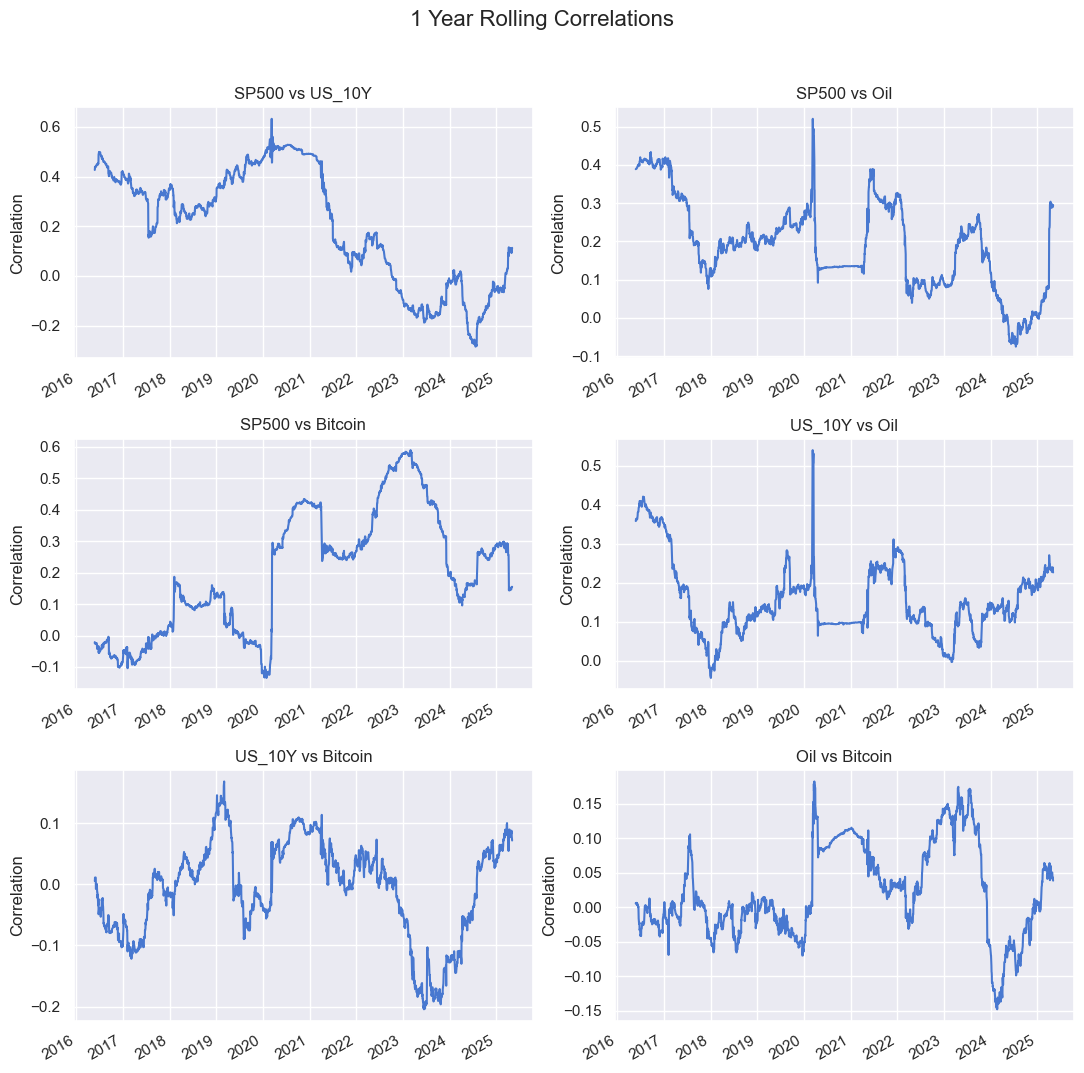

In [31]:
plot_rolling_correlations(rolling_corr_1y, "1 Year Rolling Correlations")

The rolling correlations reveal much more dynamic relationships than the static correlations suggest. The major point here is that **the correlations are not stable in time**. In particular:

1. SP500 vs US_10Y correlation has been highly unstable, ranging from around +0.6 to -0.2. The previously observed positive correlation (0.29) has actually turned negative in recent periods, indicating a significant regime shift.

2. SP500 vs Bitcoin shows the most dramatic evolution - from near-zero or negative correlation pre-2020 to much stronger positive correlations (up to 0.6) in recent years, far exceeding the static correlation of 0.21.

3. Oil correlations with other assets are quite volatile but generally remain low magnitude, consistent with the static analysis. However, they show periods of both positive and negative correlations, which the static measure masks.

This analysis demonstrates that static correlations can be misleading, as asset relationships can significantly change over time, particularly during market stress periods or regime shifts.

#### Comparison Across Different Windows

Let's also check if using different rolling windows has any effect.

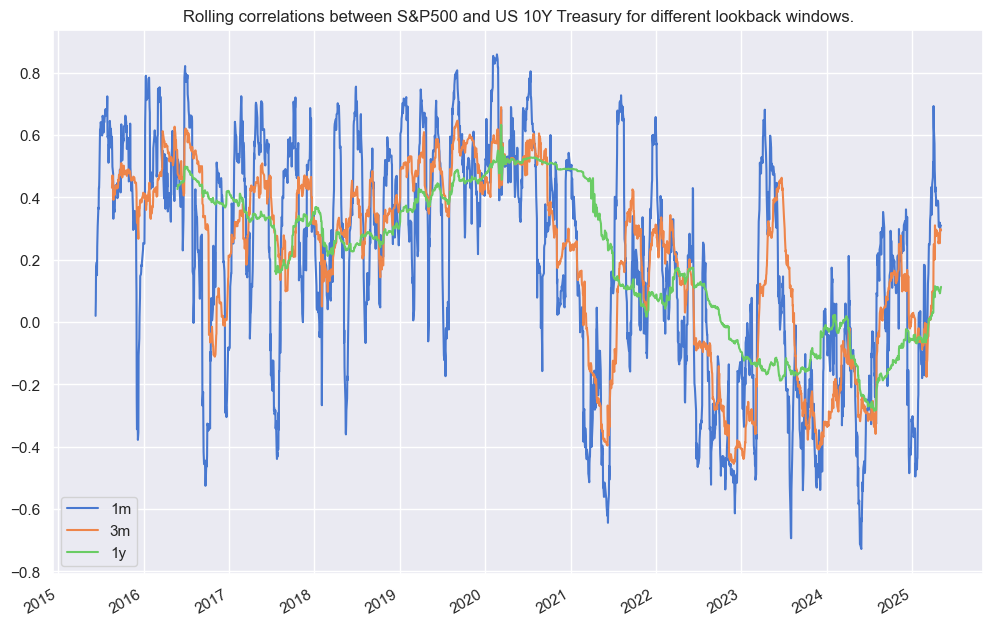

In [32]:
cross = 'SP500 vs US_10Y'

df_corr_diff_wind  = pd.concat([rolling_corr_1m[cross], rolling_corr_3m[cross], rolling_corr_1y[cross]], axis=1)
df_corr_diff_wind.columns = ['1m', '3m', '1y']
df_corr_diff_wind.plot(title='Rolling correlations between S&P500 and US 10Y Treasury for different lookback windows.', figsize=(12,8))
plt.show()

The chart clearly demonstrates two key insights about correlation measurement:

1. Not only correlations are not stable in general, but they are also not the same for different lookback windows (raising serious question which value should be used in a particualar context).

2. Shorter windows (1m) show much higher volatility in correlations, swinging dramatically between +0.8 and -0.6, while longer windows (1y) produce smoother, more stable estimates.

#### 4.3 Another look at correlations

We can also look at the correlations from a different angle. Let's consider the normalized montly returns we calculated earlier and visualize their pairwise scatterplots, looking at the historic evolution at the same time (by using different colors for different years).

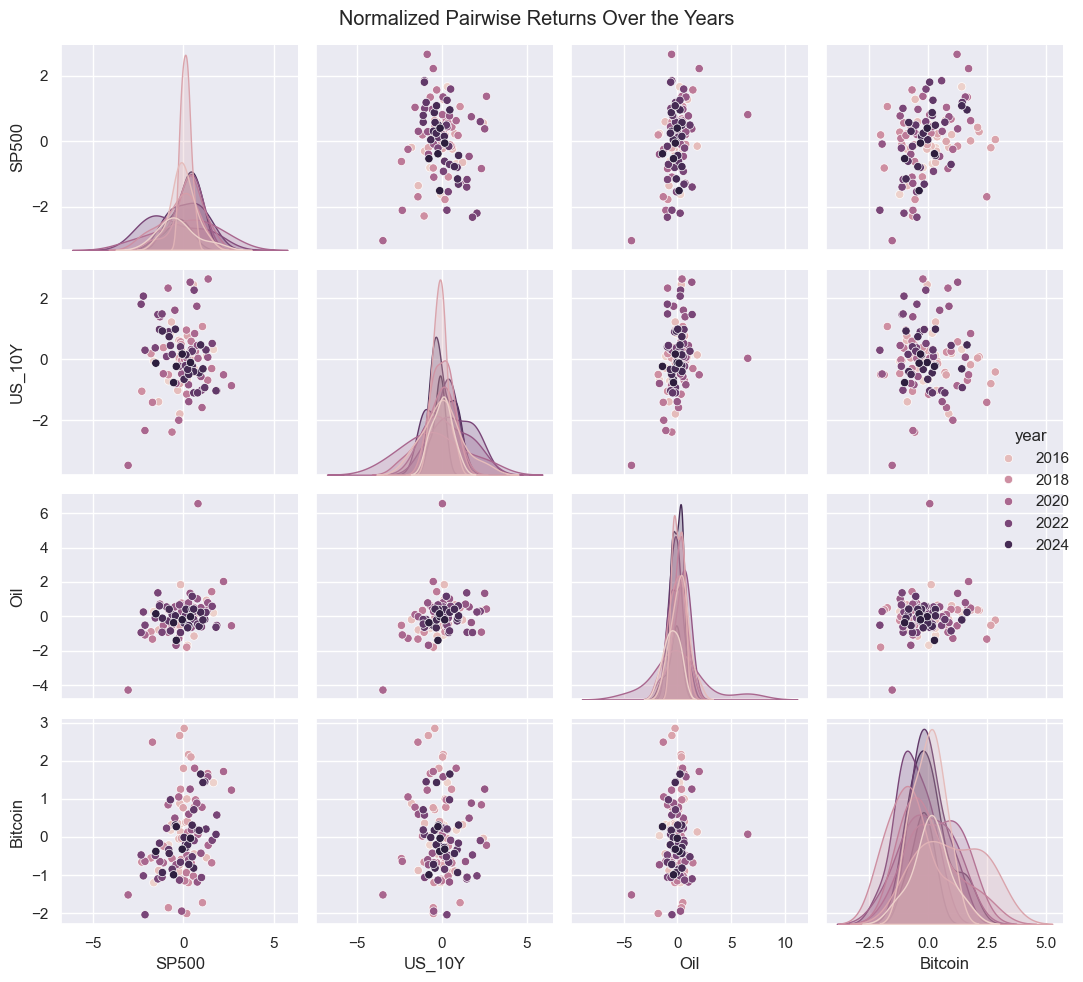

In [33]:
monthly_returns_standard_year = monthly_returns_standard.copy().assign(year=lambda x: x.index.year)
sns.pairplot(monthly_returns_standard_year, hue='year')
plt.suptitle('Normalized Pairwise Returns Over the Years')
plt.tight_layout()

The pairwise scatter plots of normalized monthly returns reveal several interesting patterns:

1. The diagonal shows return distributions for each asset, with Oil and Bitcoin displaying notably wider spreads and more extreme outliers compared to S&P500 and US 10Y yields. This agrees with our earlier results on distribution analysis. 

2. Another interesting fact from the diagonal is that the distributions of returns for the same asset are significantly different year after year. So, not only the correlations are not stable, but the return distributions themselves are not stable with time with both the mean and standard deviation dynamically changing with time (the S&P500 plot in the upper left corner, perhaps, the best example of this).

2. The temporal evolution (shown by color gradient from 2016 to 2024) suggests that relationship patterns have shifted over time. This is particularly visible in the S&P500 vs Bitcoin relationship, where more recent observations (darker points) appear to show a tighter positive correlation than earlier periods.

3. Most scatter patterns show a roughly elliptical cloud rather than a clear linear relationship, suggesting that correlations, while present, are not particularly strong or stable. This is consistent with our earlier correlation analysis.

4. The spread of points also reveals potential non-linear relationships that wouldn't be captured by simple correlation coefficients, particularly visible in some of the Bitcoin relationships where extreme events seem to coincide across assets.

This visualization reinforces our previous findings about correlation instability while providing additional insight into the evolving nature of these relationships and their behavior during extreme market moves.

***
### 5. ML for Market Regime Detection 

Our analysis of return distributions and correlations revealed significant instability in market behavior over time - both the statistical properties of individual assets and their relationships with each other vary substantially across different periods. This suggests that financial markets operate in distinct "regimes" - persistent states characterized by different patterns of volatility, correlation, and overall market dynamics. For example, periods of market stress often exhibit both higher volatility and stronger cross-asset correlations compared to calm periods.

To identify these regimes in a systematic way, we will employ both unsupervised and supervised machine learning, specifically K-means clustering and Support Vector Machine (SVM). Initially, we use K-means clustering, which allows us to group periods with similar characteristics without pre-defining what these regimes should look like, letting the data reveal natural patterns in market behavior. In particular, we will be looking for clusters of daily volatility. To enchance regime detection and classifications, we will also implment a SVM classifier. By training the SVM on volatilty based labels derived from rolling standard deviations, we allowed the model to detect between low, medium, and high volatility regimes with greater precision.

#### 5.1 K-means clustering

In [34]:
def detect_market_regimes(returns, window=22, n_clusters=3):
    """
    Apply clustering to detect market regimes
    
    Parameters:
    returns (pd.DataFrame): Returns data
    window (int): Window for rolling calculations
    n_clusters (int): Number of clusters to detect
    
    Returns:
    tuple: (Cluster labels as DataFrame, Cluster centers)
    """
    # Remove any missing values first
    returns_clean = returns.dropna()
    
    # Calculate rolling volatility
    rolling_vol = returns_clean.rolling(window=window).std().mean(axis=1)
    
    # Prepare features for clustering
    features = pd.DataFrame({
        'volatility': rolling_vol
    }).dropna()  # Remove NaN from rolling calculation
    
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features_scaled)
    
    # Convert labels to DataFrame
    labels_df = pd.DataFrame(
        labels, 
        index=features.index, 
        columns=['Regime']
    )
    
    return labels_df, kmeans.cluster_centers_

In [35]:
def plot_regime_analysis(returns, labels_df):
    """
    Plot returns colored by regime using seaborn
    
    Parameters:
    returns (pd.DataFrame): Returns data
    labels_df (pd.DataFrame): DataFrame with regime labels
    """
    # Remove any missing values first
    returns_clean = returns.dropna()
    
    # Calculate volatility
    vol = returns_clean.rolling(window=21).std().mean(axis=1)
    vol = vol.dropna()  # Remove NaN from rolling calculation
    
    # Make sure vol and labels align
    vol = vol[labels_df.index[0]:labels_df.index[-1]]
    
    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        'Date': vol.index,
        'Volatility': vol,
        'Regime': labels_df['Regime']
    })
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=plot_df, x='Date', y='Volatility', hue='Regime', palette=['green','red','blue'])
    plt.title('Market Regimes based on Volatility')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



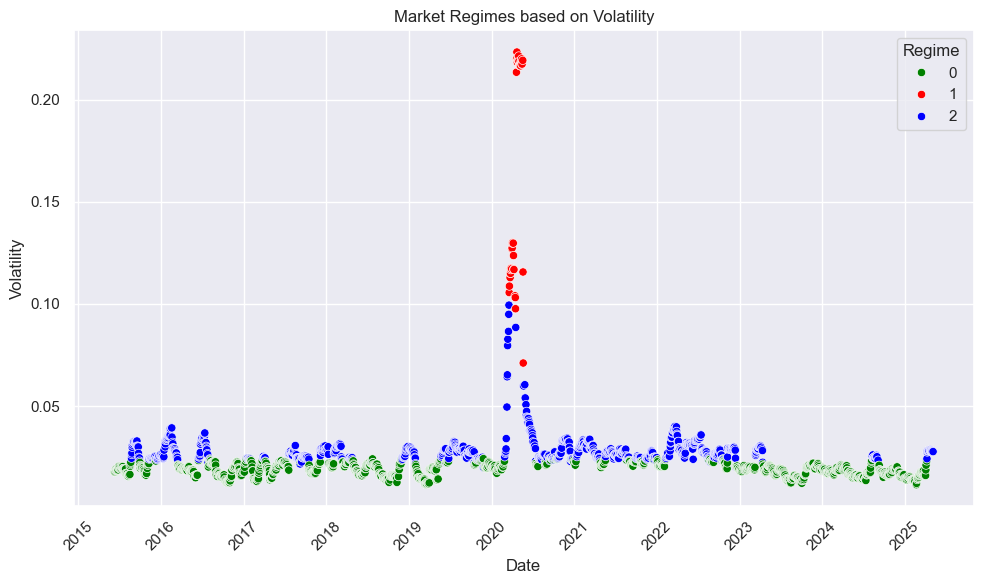

In [36]:
labels_df, centers = detect_market_regimes(daily_returns)
plot_regime_analysis(daily_returns, labels_df)

The clustering algorithm has identified three distinct market regimes based on volatility levels (we asked for three clusters for simmplicity):

1. A low-volatility regime (green dots) which appears to be the **"normal"** state of the market, dominating most of the period from 2015 to 2024 with volatility levels below 0.05.

2. A medium-volatility regime (blue dots) representing periods of elevated but not extreme **market stress**, appearing periodically throughout the sample and showing volatility levels between 0.05 and 0.10.

3. A high-volatility regime (red dots) concentrated primarily during the COVID-19 **panic** in early 2020, where volatility spiked above 0.15, representing extreme market stress.

The analysis clearly identifies the COVID-19 period as an exceptional regime, while also capturing smaller episodes of market turbulence throughout the sample period. This suggests that markets spend most time in a calm state but can transition rapidly to higher volatility regimes during crisis periods.

#### 5.2 Using cluster lables to analyze data

Now, let's overlay our regime labels with price levels and return distrubutions.

In [37]:
data_labeled = data.join(labels_df, how='inner')
data_labeled.index.name= 'date'

daily_returns_labeled = daily_returns.join(labels_df, how='inner')
daily_returns.index.name= 'date'


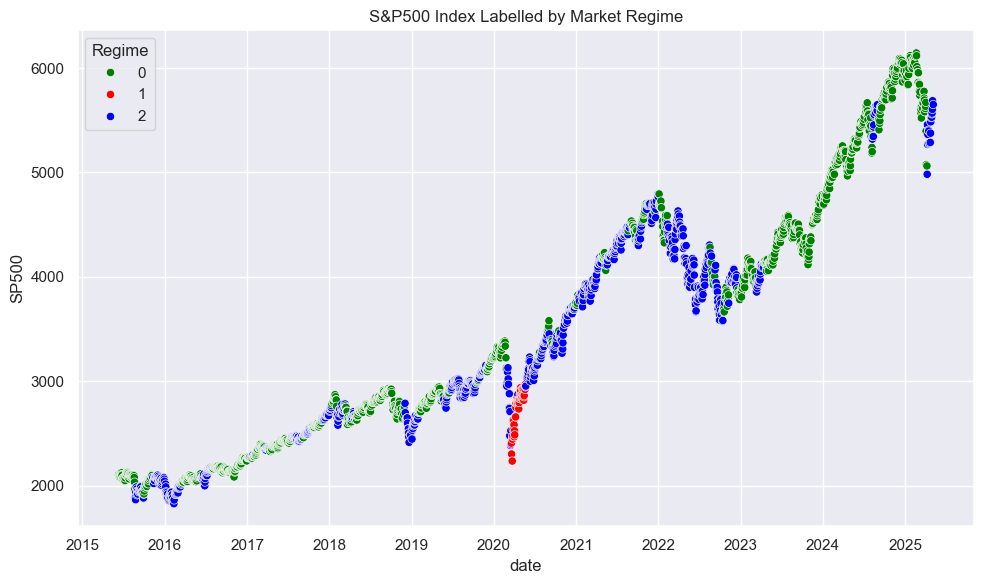

In [38]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=data_labeled, x='date', y='SP500', hue='Regime', palette=['green','red','blue'])
plt.title('S&P500 Index Labelled by Market Regime')
plt.tight_layout()
plt.show()

This visualization shows the S&P 500 index price levels colored by the market regimes previously identified through volatility clustering:

1. The green dots (Regime 0) represent the "normal" market state, which dominates most periods and is associated with steady market growth, particularly visible in the post-2020 recovery and much of 2021-2024.

2. The red dots (Regime 1) are concentrated during the COVID-19 crash in early 2020, representing the high-volatility crisis regime where the market experienced a sharp decline followed by a rapid recovery.

3. The blue dots (Regime 2) indicate periods of moderate volatility, appearing during several correction periods throughout the sample, including parts of 2016, 2018, and notably during 2022's market downturn.

The plot effectively demonstrates how market regimes often coincide with significant price movements, with high-volatility regimes typically appearing during major market corrections, while the low-volatility regime dominates during sustained upward trends.

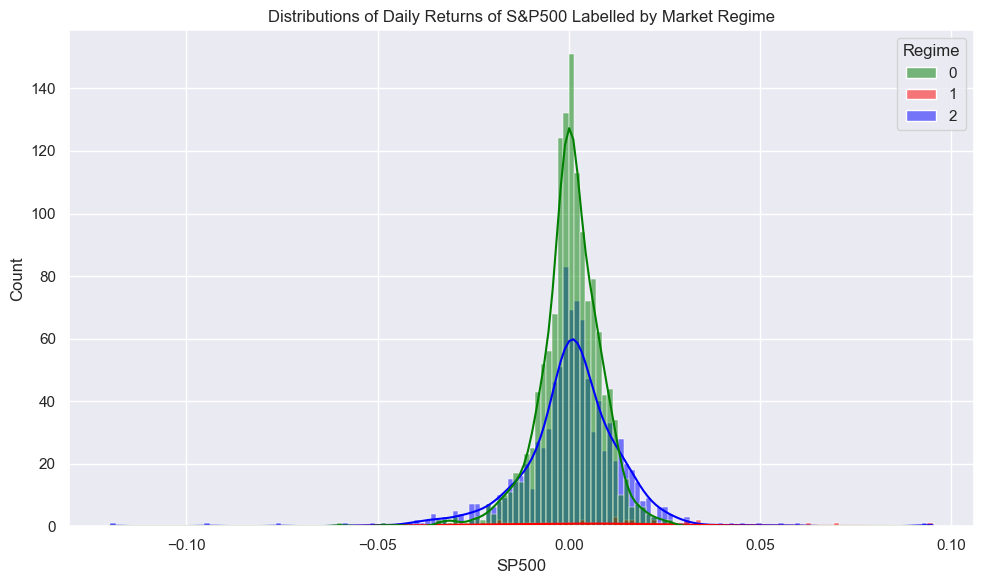

In [39]:
plt.figure(figsize=(10,6))
sns.histplot(daily_returns_labeled, x='SP500', kde=True, hue='Regime', palette=['green','red','blue'])
plt.title('Distributions of Daily Returns of S&P500 Labelled by Market Regime')
plt.tight_layout()
plt.show()

The return distributions by regime clearly illustrate their distinct characteristics: the low-volatility regime (green) shows a tall, narrow distribution centered around zero, indicating small, consistent returns. The medium-volatility regime (blue) displays a wider, flatter distribution, suggesting larger price movements. The high-volatility regime (red) appears as a very flat distribution with heavy tails, capturing the extreme returns during crisis periods. This visualization confirms that our regime classification effectively separates periods with fundamentally different return behavior.

#### 5.3 Support Vector Machine (SVM) with classification

In [40]:
rolling_vol = daily_returns['SP500'].rolling(window=20).std() # Calculate rolling volatility (standard deviation over a 20-day window)

# Label regimes: 0 = low, 1 = medium, 2 = high volatility
vol_quantiles = rolling_vol.quantile([0.33, 0.66])
low, high = vol_quantiles[0.33], vol_quantiles[0.66]

def label_volatility(vol):
    if np.isnan(vol):
        return np.nan
    elif vol < low:
        return 0
    elif vol < high:
        return 1
    else:
        return 2

regime_labels = rolling_vol.apply(label_volatility)

1. Above we calculate the 20-day rolling volatility of SP500 returns
2. Compute volatility thresholds using 333rd and 66th percentiles
3. Define and apply a function to label each day as low (0), medium (1), or high (2) volatility 

In [41]:
X_svm = daily_returns.loc[regime_labels.dropna().index] # Drop rows with NaN labels and align features
y_svm = regime_labels.dropna().astype(int)

scaler = StandardScaler() # Scale features
X_scaled = scaler.fit_transform(X_svm)

In [42]:
# 1. Drop NaNs from regime labels and feature rows
valid_index = regime_labels.dropna().index
X_svm = daily_returns.loc[valid_index].dropna()  # drop NaNs in features
y_svm = regime_labels.loc[X_svm.index].astype(int)  # realign labels to cleaned features

# 2. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_svm)

# 3. Train, test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_svm, test_size=0.3, random_state=42)

# 4. Train SVM
svm_model = SVC(kernel='rbf', C=1.0)
svm_model.fit(X_train, y_train)

# 5. Evaluate
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Low", "Medium", "High"]))

              precision    recall  f1-score   support

         Low       0.47      0.79      0.59        97
      Medium       0.35      0.17      0.23        83
        High       0.75      0.57      0.65        97

    accuracy                           0.53       277
   macro avg       0.52      0.51      0.49       277
weighted avg       0.53      0.53      0.50       277



We repeated the data cleaning we did before to ensure that both X_svm and y_svm are NaN free and aligned. Then we split the dataset into 70% training and 30% testing sets and initilized the SVM classifier.

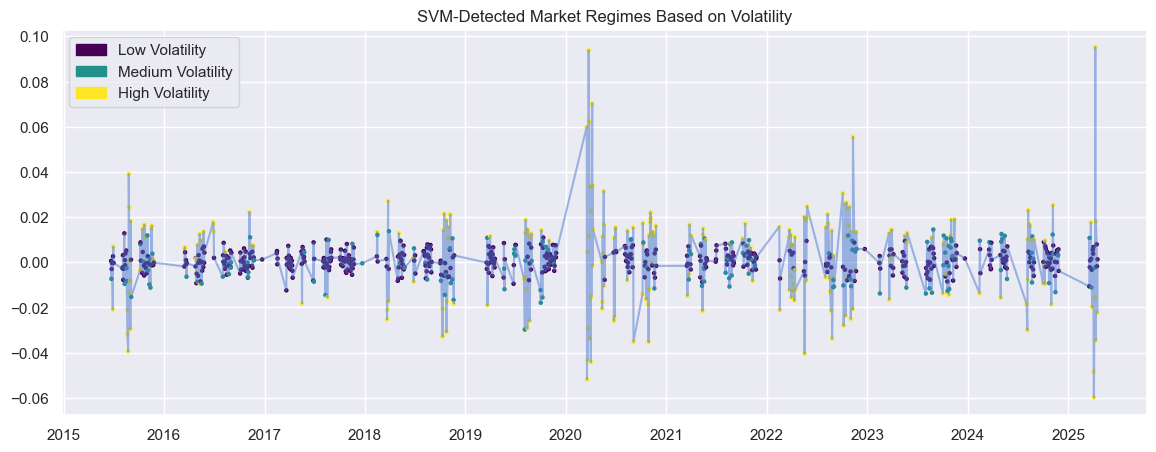

In [43]:
# Predict on entire dataset
regime_preds = svm_model.predict(X_scaled)

# Add to DataFrame for plotting
svm_results = X_svm.copy()
svm_results['Regime'] = regime_preds

# Legend
cmap = plt.cm.get_cmap('viridis', 3)  
colors = [cmap(i) for i in range(3)]
labels = ['Low Volatility', 'Medium Volatility', 'High Volatility']
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(3)]

# Plot
plt.figure(figsize=(14, 5))
plt.plot(svm_results.index, daily_returns.loc[svm_results.index, 'SP500'], label='SP500 Returns', alpha=0.5)
plt.scatter(svm_results.index, daily_returns.loc[svm_results.index, 'SP500'], c=svm_results['Regime'], cmap='viridis', s=5)
plt.title("SVM-Detected Market Regimes Based on Volatility")
plt.legend(handles=patches)
plt.show()


The plot above visually represents how financial market conditions, specifically those of the S&P 500 index, shift between different levels of market volatility. Each dot on the graph reflects a trading day between 2015 and 2025, with the vertical position representing the daily returns. The color of the dot represents the predicted volatility, with purple representing low volatility,  teal representing medium volatility, and yellow representing high volatility. The classifications for the graph were developed using a Support Vector Machine classifier that was trained on historical asset return data, with the data labels coming from a rolling 20-day volatility threshold.    


From the plot, we observe that periods of low volatility are prevalent during long stretches of market stability, such as mid-2016 to early 2018 and part of 2021. These market conditions often correlate with strong investor confidence or steady macroeconomic growth. On the other end, periods of high volatility, as shown throughout 2020 and 2023, in large part due to Covid-19. Finally, periods of medium volatility typically precede or follow high-volatility events, acting as transition zones where the market is responding to uncertainty.

### 5.4 Model Evaluation <a name="evaluation"></a>

To evaluate the performance of the K-Means clustering algorithm, we use the Silhouette Score, which measures how similar each point is to its own cluster versus other clusters.

A higher score (closer to 1) suggests well-separated clusters, while a lower or negative score indicates overlapping or poorly defined clusters.


In [44]:
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(daily_returns.dropna())

# Fit KMeans (if not already done)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_returns)

# Evaluate silhouette score
score = silhouette_score(scaled_returns, kmeans.labels_)
print(f"Silhouette Score for K-Means Clustering: {score:.2f}")

Silhouette Score for K-Means Clustering: 0.20


In [45]:
scaler = StandardScaler()
weekly_scaled = scaler.fit_transform(weekly_returns.dropna())  # dropna is important
weekly_kmeans = KMeans(n_clusters=3, random_state=42).fit(weekly_scaled)
weekly_score = silhouette_score(weekly_scaled, weekly_kmeans.labels_)
print(f"Silhouette Score for Weekly Clustering: {weekly_score:.2f}")

Silhouette Score for Weekly Clustering: 0.17


Although the silhouette scores are relatively low, this is expected in financial time series where regimes often overlap and market transitions are gradual. These scores still provide useful guidance on cluster separation and model quality.


***
### 6. Conclusion

This project examined the statistical properties of various financial asset classes and analyzed the dynamics of market regimes through the application of both unsupervised and supervised machine learning techniques. Using distributional and correlation analyses, we identified key features such as fat tails, skewness, and volatility clustering—particularly during periods of heightened market turbulence.

K-Means clustering was implemented to uncover and visualize latent market regimes, while Support Vector Machine (SVM) was utilized as a supervised method to classify and validate these regimes. The SVM model enabled the development of a predictive framework for identifying prevailing market conditions based on observed features, demonstrating the potential for real-time regime classification.

Our granularity analysis further revealed that the resolution of return data (daily vs weekly) can significantly influence the clarity and responsiveness of regime detection. While weekly data provides a smoother view of market trends, daily data captures more nuanced, short-term regime transitions.

Overall, our findings highlight the value of data-driven approaches for understanding asset behavior and enhancing investment strategies. The integration of machine learning techniques into financial analysis offers a practical pathway for improving risk assessment and portfolio management in dynamic market environments. Future work could incorporate additional features or explore regime transitions to further refine these models.

